<a href="https://colab.research.google.com/github/Ayush-Kori/Quant-Dev-/blob/main/Backtesting_GLD_and_GDX_hedge_ration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
df1 = pd.read_excel('GLD.xls')
df2 = pd.read_excel('GDX.xls')
df = pd.merge(df1, df2, on='Date', suffixes=('_GLD', '_GDX'))

In [ ]:
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
trainset=np.arange(0, 252)
testset=np.arange(trainset.shape[0], df.shape[0])

Determine hedge ration on trainset

In [ ]:
model=sm.OLS(df.loc[:, 'Adj Close_GLD'].iloc[trainset], df.loc[:, 'Adj Close_GDX'].iloc[trainset])
results=model.fit()
hedgeRatio=results.params
print(hedgeRatio)

Adj Close_GDX    1.631009
dtype: float64


Spread = GLD - hedgeRatio*GDX

/tmp/ipython-input-3457378258.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread=df.loc[:, 'Adj Close_GLD']-hedgeRatio[0]*df.loc[:, 'Adj Close_GDX']


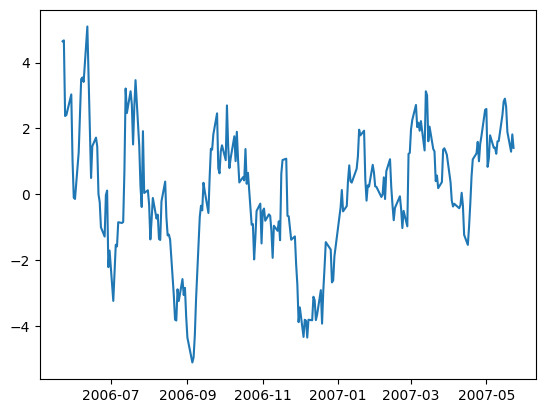

In [ ]:
spread=df.loc[:, 'Adj Close_GLD']-hedgeRatio[0]*df.loc[:, 'Adj Close_GDX']
plt.plot(spread.iloc[trainset])

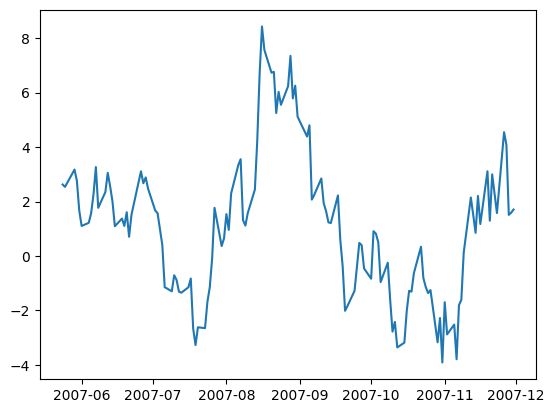

In [ ]:
plt.plot(spread.iloc[testset])

In [ ]:
spreadMean=np.mean(spread.iloc[trainset])
spreadMean

np.float64(0.05219623850036005)

In [ ]:
spreadStd=np.std(spread.iloc[trainset])
spreadStd

1.944860873496509

In [ ]:
df['zscore']=(spread-spreadMean)/spreadStd
df['positions_GLD_Long']=0
df['positions_GDX_Long']=0
df['positions_GLD_Short']=0
df['positions_GDX_Short']=0
df.loc[df.zscore>=2, ('positions_GLD_Short', 'positions_GDX_Short')]=[-1,1] # Short Spread
df.loc[df.zscore<=-2,('positions_GLD_Long', 'positions_GDX_Long')]=[1,-1] # Buy  Spread
df.loc[df.zscore<=1, ('positions_GLD_Short', 'positions_GDX_Short')]=0 #Exit short spred
df.loc[df.zscore>=-1, ('positions_GLD_Long', 'positions_GDX_Long')]=0 #Exit Long spread
df.fillna(method='ffill', inplace=True) # ensure existinf postions are carried forwarward unless there is an exit signal

/tmp/ipython-input-3301653895.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True) # ensure existinf postions are carried forwarward unless there is an exit signal


In [ ]:
positions_Long=df.loc[:,('positions_GLD_Long', 'positions_GDX_Long')]
positions_Short=df.loc[:,('positions_GLD_Short','positions_GDX_Short')]
positions=np.array(positions_Long)+np.array(positions_Short)
positions=pd.DataFrame(positions)

In [ ]:
dailyret=df.loc[:, ('Adj Close_GLD', 'Adj Close_GDX')].pct_change()
pnl=(np.array(positions.shift())*np.array(dailyret)).sum(axis=1)

In [ ]:
sharpeTrainset=np.sqrt(252)*np.mean(pnl[trainset[1:]])/np.std(pnl[trainset[1:]])
sharpeTrainset

np.float64(1.9182982282569077)

In [ ]:
sharpeTestset=np.sqrt(252)*np.mean(pnl[testset])/np.std(pnl[testset])
sharpeTestset

np.float64(1.494313761833427)

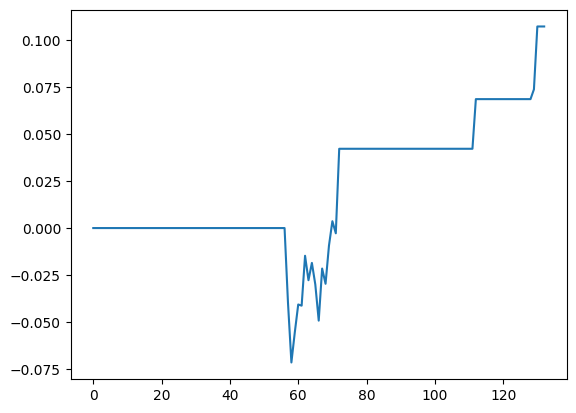

In [ ]:
plt.plot(np.cumsum(pnl[testset]))

In [ ]:
positions.to_pickle('example3_6_positions')